# This notebook shall serve as a base to experiment with simple API calls from the DocuCam API.

Objectives, write scripts for:

* Obtain an image for a specific timestamp. 
* Obtain images for a specific time range (1day+)
* Understand the data structure --> Full Images and their respective layers (500?). How to obtain them.
* Obtain image + layers or only specific layers. 

In the end, we would want to have a script that takes some parameters as input (time range, location, quality, etc) and outputs a dataframe that combines both: Measurements per timestamp and the image plus the respective layers per timestamp. Images may be appended as simple numerical representations OR in the first step simply provide path to were image is stored. 

Problem: time stamps not in sync. Need to create a costum common identifier? 


# Swagger API address:

https://langenthal.hesotech.eu/DocuCam/api/index.html

In [26]:
import requests

# set src folder as default path to easily import helper functions
import glob, os, sys; sys.path.append('../src')
from IPython.display import Image, display

In [27]:
# import certificates and keys for access
clientCrt = "../certificates/pilot-users.crt"
clientKey = "../certificates/pilot-users.key"

In [36]:
# example query to get the latest image from scene 0 (A1), layer 1, column 1, row 1.

url = "https://langenthal.hesotech.eu/DocuCam/Image/0/0/0/0/latest"

headers = {'content-type': 'image/jpeg'}

r = requests.get(url, headers=headers, cert=(clientCrt, clientKey))

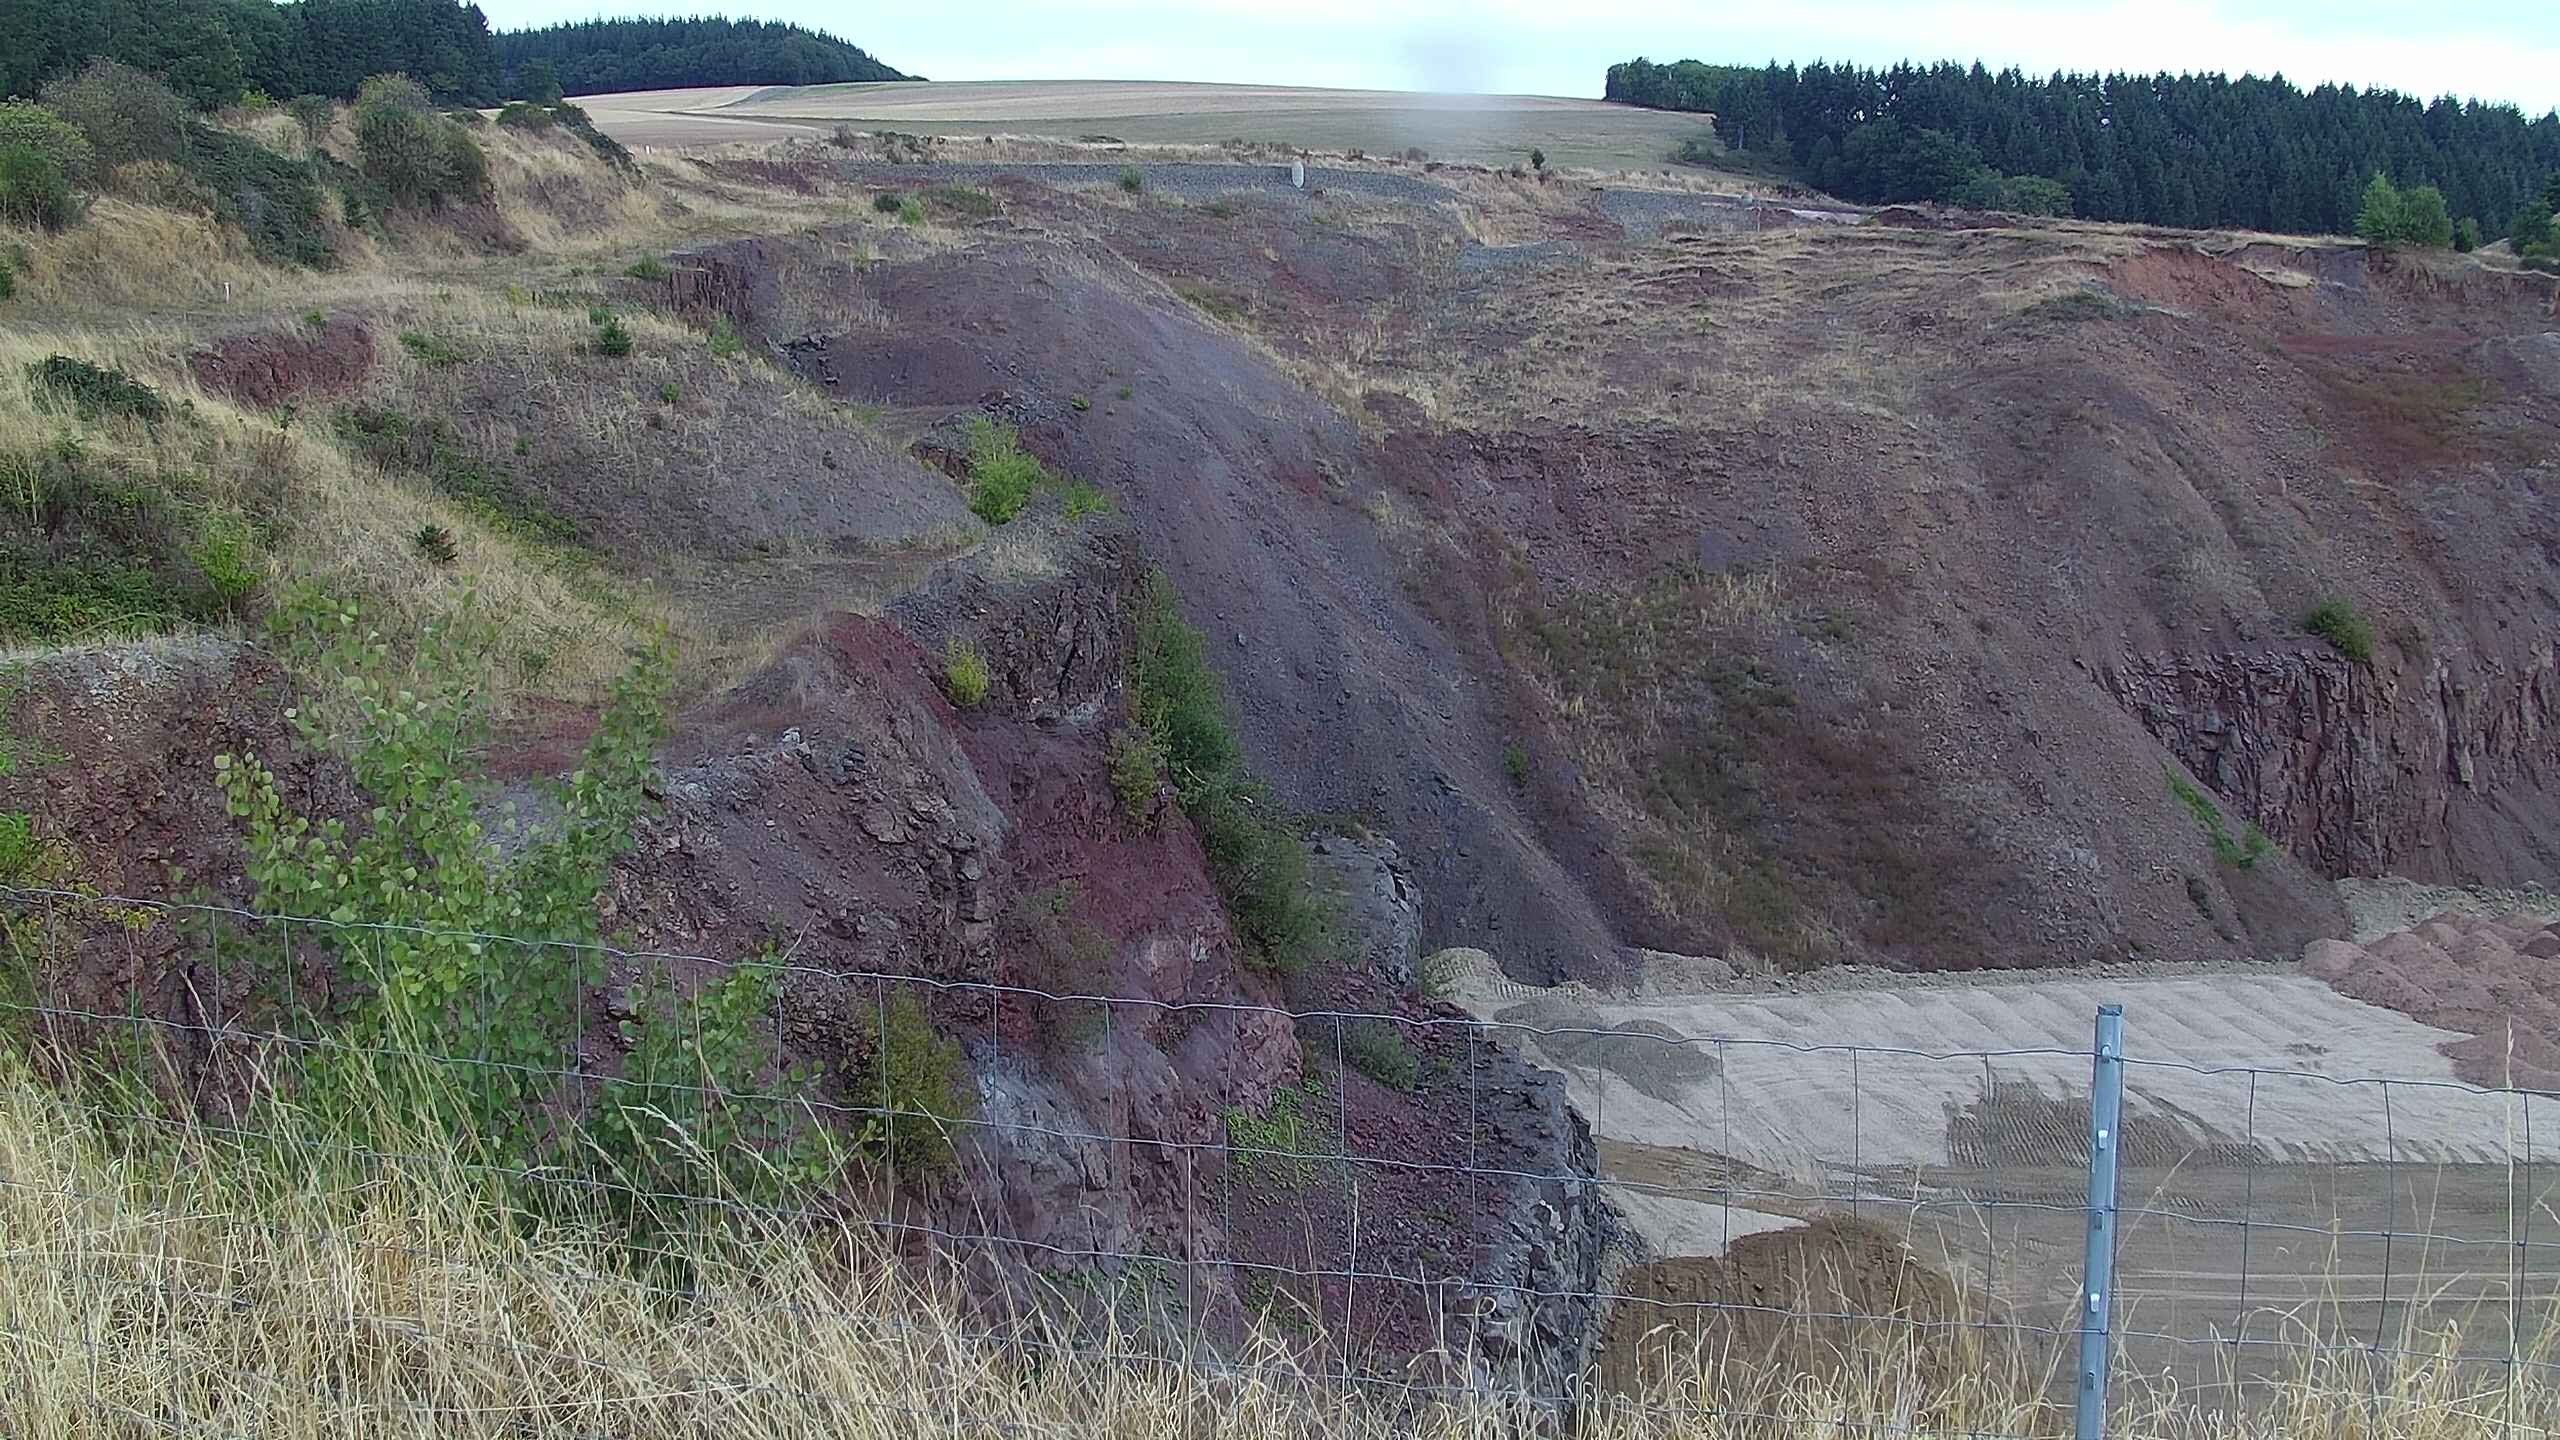

In [34]:
display(Image(r.content))

Notes:

* build a query function that takes the parameters as inputs and returns url and singe image

In [115]:
def query_image(scence, layer, column, row, timestamp = "latest") -> str:
    
    spacing = "/"
    scence = str(scence) + spacing
    layer = str(layer) + spacing
    column = str(column) + spacing
    row = str(row) + spacing
    timestamp = str(timestamp)
        
    
    request_url_base = "https://langenthal.hesotech.eu/DocuCam/Image/"
    
    url = request_url_base + scence + layer + column + row + timestamp
    
    headers = {'content-type': 'image/jpeg'}

    r = requests.get(url, headers=headers, cert=(clientCrt, clientKey))
    
    return url, r

In [116]:
url, r = query_image(1,0,0,0)
url

'https://langenthal.hesotech.eu/DocuCam/Image/1/0/0/0/latest'

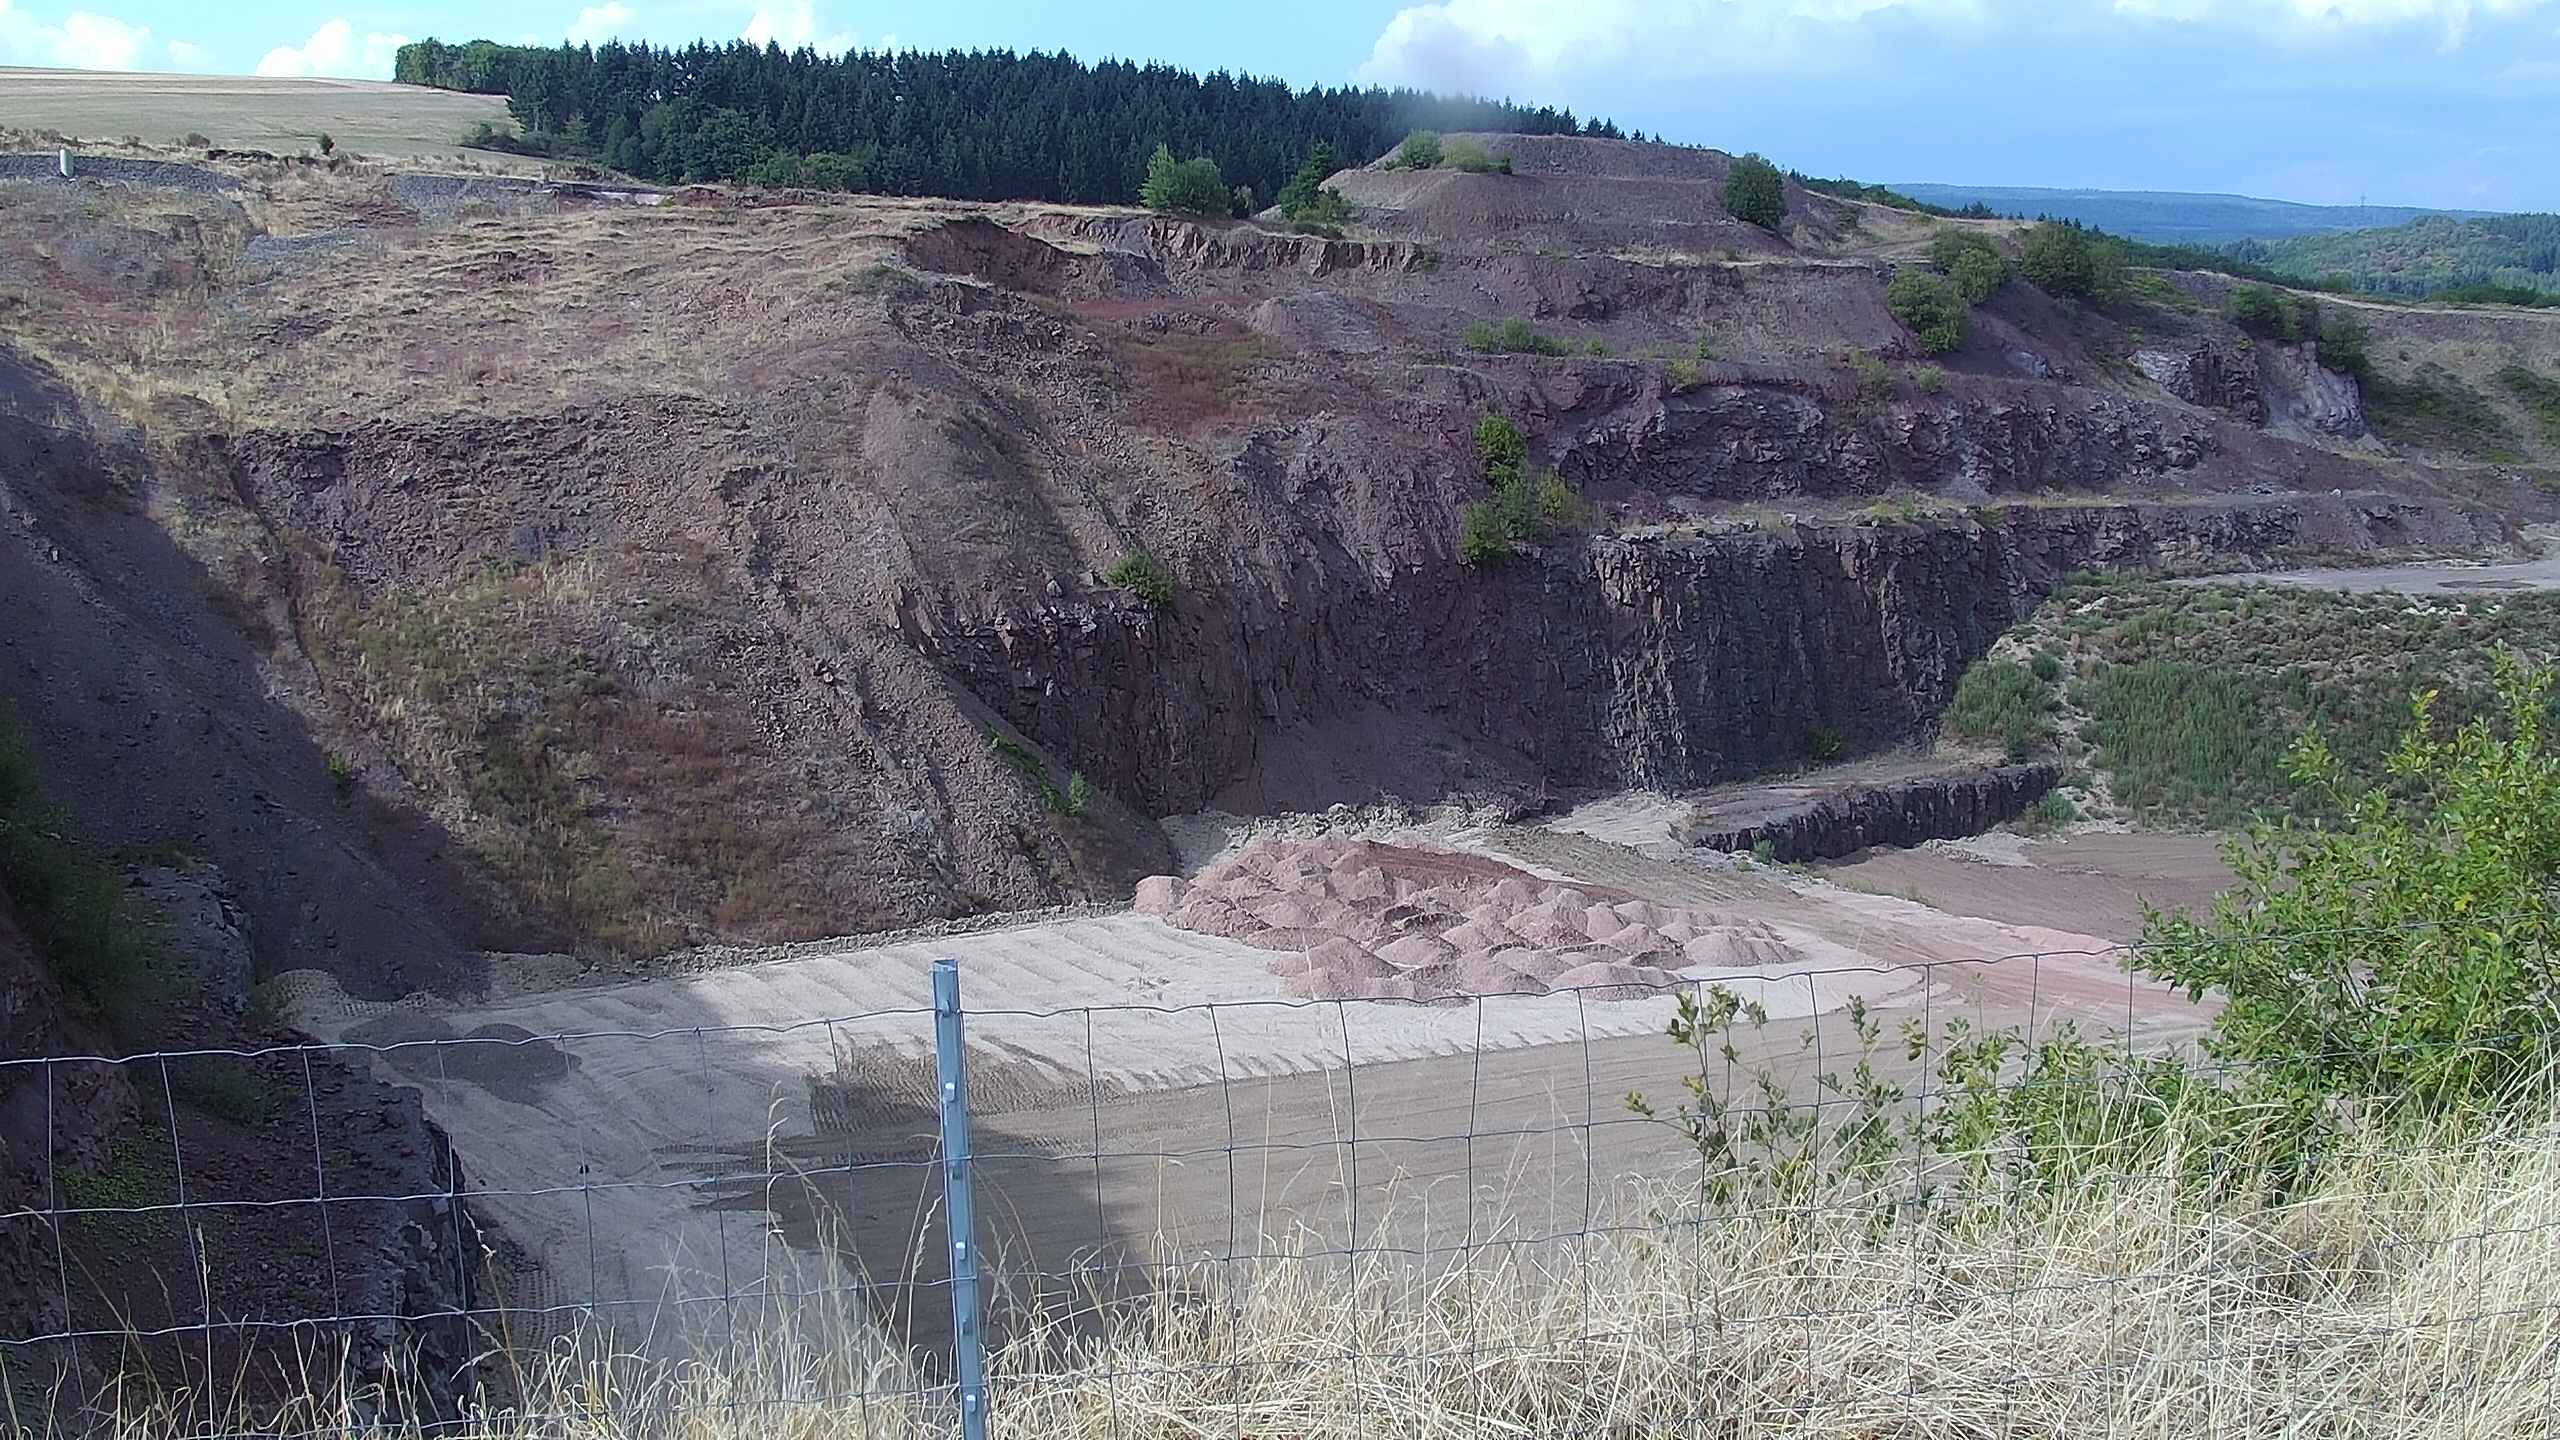

In [117]:
display(Image(r.content))